In [17]:
from glob import glob
import numpy as np
from astropy.table import QTable, vstack
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import interp1d
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')
plt.style.use('paper')

In [18]:
def custom_sort(arr):
    def key_func(item):
        num = int(item[4:])  # 'conf' has length 4
        return (num == 10, num)
    return sorted(arr, key=key_func)

def get_mrs(ratio_arr, wide_arr, n=100000, ymin=0.499, ymax=0.501, skip=3):

    wide_arr_ = wide_arr.copy()

    ratio_arr[(ratio_arr>1) | (ratio_arr<0)] = np.nan

    mask = np.isfinite(ratio_arr)
    ratio_arr = ratio_arr[mask]
    wide_arr_ = wide_arr_[mask]

    f = interp1d(wide_arr_[skip:], ratio_arr[skip:], fill_value="extrapolate")

    xarr_m = []
    factor = 1 
    while len(xarr_m)<1:
        factor += 0.1
        xarr = np.linspace(0,np.nanmax(wide_arr)*factor, n)
        farr = f(xarr)
        xarr_m = xarr[(farr>ymin)&(farr<ymax)]  

    stats1 = np.percentile(xarr_m, [0,50,100])
    stats2 = np.nanmean(xarr_m)

    stats = {'min':stats1[0],'med':stats1[1],'max':stats1[2],'mean':stats2}

    return(stats)

In [19]:
def get_mrs_baseline(baseline):
    theta_mrs = 0.983 * (3e8/100e9) / np.array(baseline)
    theta_mrs = theta_mrs * u.radian
    return(theta_mrs.to('arcsec').value)

In [20]:
which = 'disks'
version = '_disks_v1'

# which_times = ['_6totaltime', '_6totaltime_flagged', '_60totaltime', '_60totaltime_flagged', 
#                '_6totaltime_noise', '_6totaltime_flagged_noise', '_60totaltime_noise', '_60totaltime_flagged_noise']

which_times = ['_6totaltime', '_6totaltime_flagged',  
               '_60totaltime', '_60totaltime_flagged']

# which_times = ['_60totaltime']

min_baseline =  [8.7, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 64.0, 110.4, 367.6, 244.0]
min_baseline5 =  [9.1, 21.4, 27.0, 37.6, 54.1, 90.9, 148.6, 235.2, 427.3, 746.9, 1228.1]
mrs_size =       get_mrs_baseline(min_baseline)
mrs_size5_ =      [66.7, 28.5, 22.6, 16.2, 11.2, 6.7, 4.11, 2.58, 1.42, 0.814, 0.496]
mrs_size5 =      get_mrs_baseline(min_baseline5)
beam_size =     [12.5, 3.38, 2.3, 1.42, 0.918, 0.545, 0.306, 0.211, 0.096, 0.057, 0.042]
configuration = ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
mrs_conf = np.arange(0,11)
tables = {}
for which_time in which_times: 
    
    table = vstack([QTable.read(file) for file in glob(f'../data/tables{version}/table_fit_{which}{which_time}_conf*.fits')])
    conf_unique = np.unique(table['conf']) 
    conf_unique =  custom_sort(conf_unique)
    conf_unique_ = np.unique(table['conf_']) 

    print('%s %s' %(which_time, conf_unique))

    table.sort('conf')
    tables[which_time] = table
    print(table.colnames)

_6totaltime ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
['conf', 'wide', 'sum_sim', 'sum_obs', 'rms_obs', 'max_sim', 'max_obs', 'sum_fit_sim', 'sum_fit_obs', 'errl_fit_sim', 'errh_fit_sim', 'errl_fit_obs', 'errh_fit_obs', 'sum_mask10_sim', 'sum_mask10_obs', 'sum_mask50_sim', 'sum_mask50_obs', 'conf_', 'wide_']
_6totaltime_flagged ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
['conf', 'wide', 'sum_sim', 'sum_obs', 'rms_obs', 'max_sim', 'max_obs', 'sum_fit_sim', 'sum_fit_obs', 'errl_fit_sim', 'errh_fit_sim', 'errl_fit_obs', 'errh_fit_obs', 'sum_mask10_sim', 'sum_mask10_obs', 'sum_mask50_sim', 'sum_mask50_obs', 'conf_', 'wide_']
_60totaltime ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
['conf', 'wide', 'sum_sim', 'sum_obs', 'rms_obs', 'max_sim', 'max_obs', 'sum_fit_sim', 'sum_fit_obs', 'errl_fit_sim', 'errh_fit_sim', 'errl_

In [21]:
tables_mrs = {}
for which_time in which_times: 
	print(which_time)

	table = tables[which_time] 
	conf_unique = np.unique(table['conf']) 
	conf_unique = custom_sort(conf_unique)
	conf_unique_ = np.unique(table['conf_']) 
	
	# Get ratio 50percent for table
	ratio_fit_50percent_arr = np.ones(len(conf_unique))
	ratio_fiterrl_50percent_arr = np.ones(len(conf_unique))
	ratio_fiterrh_50percent_arr = np.ones(len(conf_unique))
	ratio_mask10_50percent_arr = np.ones(len(conf_unique))

	for i, conf in enumerate(conf_unique):

		conf_tab = table[np.where(table['conf']==conf)]
		conf_arr = conf_tab['conf']
		wide_arr = [''] * len(conf_arr)

		sum_sim = conf_tab['sum_sim'].value
		sum_obs = conf_tab['sum_obs'].value
		sum_mask10_obs = conf_tab['sum_mask10_obs'].value
		sum_mask10_sim = conf_tab['sum_mask10_sim'].value
		sum_mask50_obs = conf_tab['sum_mask50_obs'].value
		sum_mask50_sim = conf_tab['sum_mask50_sim'].value
		ratio_arr = sum_obs/sum_sim
		ratio_mask10_arr = sum_mask10_obs/sum_mask10_sim
		ratio_mask50_arr = sum_mask50_obs/sum_mask50_sim

		for j, wide in enumerate(conf_tab['wide']):
			wide_arr[j] = float(wide.replace('mrs0',''))
		wide_arr = np.array(wide_arr)

		ids = np.argsort(wide_arr)
		wide_arr = wide_arr[ids]
		ratio_arr = ratio_arr[ids]
		ratio_mask10_arr = ratio_mask10_arr[ids]
		ratio_mask50_arr = ratio_mask50_arr[ids]

		ratio_mask10_50percent_arr[i] = get_mrs(ratio_mask10_arr, wide_arr, skip=3)['mean']

	data = [conf_unique, conf_unique_, ratio_mask10_50percent_arr]
	names = ['conf', 'conf_', 'ratio_mask10_50percent']

	tables_mrs[which_time] = QTable(data, names=names)
tables_mrs.keys()

_6totaltime
_6totaltime_flagged
_60totaltime
_60totaltime_flagged


dict_keys(['_6totaltime', '_6totaltime_flagged', '_60totaltime', '_60totaltime_flagged'])

In [22]:
tables_mrs['_6totaltime_comb'] = vstack([tables_mrs['_6totaltime'][:4], tables_mrs[ '_6totaltime_flagged'][4:]])
tables_mrs['_60totaltime_comb'] = vstack([tables_mrs['_60totaltime'][:4], tables_mrs[ '_60totaltime_flagged'][4:]])

which_times = ['_6totaltime_comb', '_60totaltime_comb']

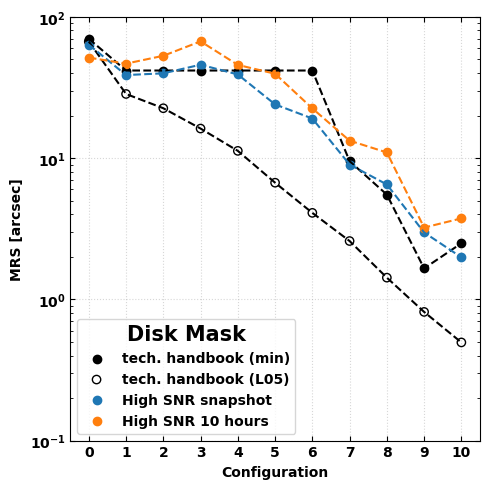

In [23]:
fig1, ax1 = plt.subplots(1,1, figsize=(5, 5))

ax1.plot(mrs_conf, mrs_size, c='k', ls='--')
ax1.scatter(mrs_conf, mrs_size, c='k', label='tech. handbook (min)')

ax1.plot(mrs_conf, mrs_size5, c='k', ls='--')
ax1.scatter(mrs_conf, mrs_size5, ec='k', fc='none', label='tech. handbook (L05)')

for i, which_time in enumerate(list(which_times)):

    table = tables_mrs[which_time] 

    conf = np.array(table['conf_'])
    r_mask10 = np.array(table['ratio_mask10_50percent'])

    # Make label 
    time = which_time.split('totaltime')[0].split('_')[-1]
    if time == '6': 
        time = 'snapshot'
    else: 
        time = '10 hours'
    label = which_time.split('totaltime')[-1]
    label = label.replace('_', '')
    label = label.replace('comb', '')
    if 'noise' in label:
        label.replace('noise', 'Low SNR')
    else: 
        label='%sHigh SNR' %(label)
    #
        
    ax1.plot(conf, r_mask10, ls='--', color='C%i'%i)
    ax1.scatter(conf, r_mask10, label='%s %s' %(label, time), color='C%i'%i)

ax1.set_ylim([0.1, 1e2])
ax1.set_xlim([-0.5,10.5])
ax1.set_xlabel('Configuration')
ax1.set_ylabel('MRS [arcsec]')
ax1.grid(True, ls=':', alpha=0.5)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(1))

ax1.legend(loc='lower left', fontsize=10, title='Disk Mask', title_fontsize=15)
ax1.set_yscale('log')

fig1.tight_layout()
fig1.savefig(f'./../figs/mrs_mask_{which}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/mrs_mask_{which}.png', dpi=300, bbox_inches='tight', transparent=False)

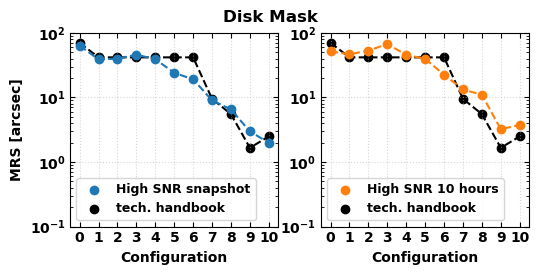

In [24]:
fig1, ax = plt.subplots(1, 2, figsize=(5.5, 3))
ax = ax.flatten()

for i, which_time in enumerate(list(which_times)):
    
    table = tables_mrs[which_time] 

    conf = np.array(table['conf_'])
    r_mask10 = np.array(table['ratio_mask10_50percent'])

    # Make label 
    time = which_time.split('totaltime')[0].split('_')[-1]
    if time == '6': 
        time = 'snapshot'
    else: 
        time = '10 hours'
    label = which_time.split('totaltime')[-1]
    label = label.replace('_', '')
    label = label.replace('comb', '')
    if 'noise' in label:
        label.replace('noise', 'Low SNR')
    else: 
        label='%sHigh SNR' %(label)
    #

    ax[i].plot(conf, r_mask10, ls='--', color='C%i'%i)
    ax[i].scatter(conf, r_mask10, label='%s %s' %(label, time), color='C%i'%i)

    ax[i].plot(mrs_conf, mrs_size, c='k', ls='--', zorder=-1)
    ax[i].scatter(mrs_conf, mrs_size, c='k', zorder=-1, label='tech. handbook')

for ax_ in ax: 
    ax_.grid(True, ls=':', alpha=0.5)
    ax_.xaxis.set_major_locator(MultipleLocator(1))
    ax_.yaxis.set_minor_locator(MultipleLocator(2))
    ax_.set_ylim([-1,82])
    ax_.set_xlim([-0.5,10.5])
    ax_.legend(loc='upper right', fontsize=9)

fig1.suptitle('Disk Mask', fontweight='bold', y=0.9)

ax[0].set_ylabel('MRS [arcsec]')

for i in [0,1]:
    ax[i].set_xlabel('Configuration')

for ax_ in ax: 
    ax_.set_yscale('log')
    ax_.set_ylim([0.1, 1e2])
    ax_.legend(loc='lower left', fontsize=9)


fig1.tight_layout(w_pad=0.1, h_pad=0.1)
fig1.savefig(f'./../figs/mrs_mask_all_{which}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/mrs_mask_all_{which}.png', dpi=300, bbox_inches='tight', transparent=False)